# Import required packages

In [1]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, balanced_accuracy_score
import matplotlib.pyplot as plt
from numpy import load
import os
import pickle
import numpy as np
import tensorflow_addons as tfa
import sklearn.metrics as metrics


#  Set paths

In [2]:
#set path to model folder
model_path = 'C:\\Users\\SWONG\\PRS_project\\Model\\'

#input name of model to be tested
model_name_NN = 'Final_Arbitrator_6lyr_binaryCross_Weight5_YesAug_0.5Dropout.hdf5'
model_name_LR = 'LogReg_Arbitrator.sav'
model_name_SVM = 'SVM_Arbitrator.sav'
arr_path = 'C:\\Users\\SWONG\\PRS_project\\Model\\numpy_baseClassifier_predictions\\'

#set path to test images
test_full_image_path_pos = 'C:\\Users\\SWONG\\PRS_project\\Data_Set\\test\\melanoma\\images\\'
test_full_image_path_neg = 'C:\\Users\\SWONG\\PRS_project\\Data_Set\\test\\non_melanoma\\images\\'

test_asym_image_path_pos = 'C:\\Users\\SWONG\\PRS_project\\Asym_data\\test\\melanoma\\'
test_asym_image_path_neg = 'C:\\Users\\SWONG\\PRS_project\\Asym_data\\test\\non_melanoma\\'

test_border_image_path_pos = 'C:\\Users\\SWONG\\PRS_project\\Border_data\\test\\melanoma\\'
test_border_image_path_neg = 'C:\\Users\\SWONG\\PRS_project\\Border_data\\test\\non_melanoma\\'

test_center_image_path_pos = 'C:\\Users\\SWONG\\PRS_project\\Data_Set\\test\\melanoma\\center_cropped\\'
test_center_image_path_neg = 'C:\\Users\\SWONG\\PRS_project\\Data_set\\test\\non_melanoma\\center_cropped\\'

test_bluewh_image_path_pos = 'C:\\Users\\SWONG\\PRS_project\\Data_Set\\test\\melanoma\\images\\'
test_bluewh_image_path_neg = 'C:\\Users\\SWONG\\PRS_project\\Data_Set\\test\\non_melanoma\\images\\'

# Store test image names in lists

In [3]:
#getting the lists of melanoma and non_melanoma images
image_list_pos = os.listdir(test_full_image_path_pos)
image_list_neg = os.listdir(test_full_image_path_neg)

image_full_list_all = []
image_asym_list_all = []
image_border_list_all = []
image_center_list_all = []
image_bluewh_list_all = []

for image in image_list_pos:
    image_full_list_all.append(os.path.join(test_full_image_path_pos,image))
    image_asym_list_all.append(os.path.join(test_asym_image_path_pos,image))
    image_border_list_all.append(os.path.join(test_border_image_path_pos,image))
    image_center_list_all.append(os.path.join(test_center_image_path_pos,image))
    image_bluewh_list_all.append(os.path.join(test_bluewh_image_path_pos,image))
    
for image in image_list_neg:
    image_full_list_all.append(os.path.join(test_full_image_path_neg,image))
    image_asym_list_all.append(os.path.join(test_asym_image_path_neg,image))
    image_border_list_all.append(os.path.join(test_border_image_path_neg,image))
    image_center_list_all.append(os.path.join(test_center_image_path_neg,image))
    image_bluewh_list_all.append(os.path.join(test_bluewh_image_path_neg,image))

# Load models to be tested 

In [4]:
#load models to be tested
model_NN = load_model(os.path.join(model_path,model_name_NN))
model_LR = pickle.load(open(model_path+model_name_LR, 'rb'))
model_SVM = pickle.load(open(model_path+model_name_SVM, 'rb'))

In [5]:
# load numpy arrays (base model predictions) from npy file to test LogReg and SVM arbitrator
np_test_asym_preds = load(arr_path+'test_preds_asym.npy')
np_test_border_preds = load(arr_path+'test_preds_border.npy')
np_test_center_preds = load(arr_path+'test_preds_center.npy')
np_test_orig_preds = load(arr_path+'test_preds_orig.npy')
np_test_blueWhite_preds = load(arr_path+'test_preds_blueWhite.npy')

# Function to preprocess test images to feed into model

In [6]:
from tensorflow.keras.preprocessing import image

#preprocessing images to a nparray
def image_preprocessing_all(img_list):
    images = []
    for img in img_list:
        img = image.load_img(img,target_size=(224,224))
        images.append(np.asarray(img))
    images_np = np.array(images)
    return images_np

#storing all the test images in nparray format
images_full_np = image_preprocessing_all(image_full_list_all)
images_asym_np = image_preprocessing_all(image_asym_list_all)
images_border_np = image_preprocessing_all(image_border_list_all)
images_center_np = image_preprocessing_all(image_center_list_all)
images_bluewh_np = image_preprocessing_all(image_bluewh_list_all)


print(images_full_np.shape)

(1002, 224, 224, 3)


# Storing the true image labels in a list (Y_test)

In [7]:
#storing the true label for the images in labelled_class
Y_test = []
for img in image_list_pos:
    Y_test.append(0)
for img in image_list_neg:
    Y_test.append(1)

# Predict test image classes and store results 

In [8]:
#class probabilites for each image in test set
raw_pred_probs = model_NN.predict([images_full_np,images_asym_np,images_border_np,images_center_np,images_bluewh_np])

In [15]:
#class predictions for each image based on probabilities
Y_pred = []
threshold = 0.5
for pred in raw_pred_probs:
    if (pred[0] <= threshold):
        Y_pred.append(0)
    elif (pred[0] > threshold):
        Y_pred.append(1)
    
print('Length of raw_pred_probs list: ', len(raw_pred_probs))
print('Array shape of raw_pred_probs[0]: ', raw_pred_probs[0].shape)
print('Length of pred_class list: ', len(Y_pred))
print('Length of labelled_class list: ',len(Y_test))

Length of raw_pred_probs list:  1002
Array shape of raw_pred_probs[0]:  (1,)
Length of pred_class list:  1002
Length of labelled_class list:  1002


In [10]:
# Concatenate the np arrays of base model predictions to form input test data for LogReg and SVM models
X_test = np.concatenate(np.array([np_test_asym_preds, np_test_border_preds, np_test_center_preds, np_test_orig_preds, np_test_blueWhite_preds]), axis=1)

In [11]:
#perform prediction on test data
lr_pred_proba = model_LR.predict_proba(X_test)
svm_pred_proba = model_SVM.predict_proba(X_test)

# Report classification metrics

# Final Arbitrator (NN)

In [16]:
labelname = ['melanoma', 'non_me']
testScores  = metrics.accuracy_score(Y_test,Y_pred)

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print("Balanced Accuracy:%.2f%%" %(balanced_accuracy_score(Y_test, Y_pred)*100))
print(metrics.classification_report(Y_test,
                                    Y_pred,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 91.92%
Balanced Accuracy:86.38%
              precision    recall  f1-score   support

    melanoma     0.6027    0.7928    0.6848       111
      non_me     0.9731    0.9349    0.9536       891

    accuracy                         0.9192      1002
   macro avg     0.7879    0.8638    0.8192      1002
weighted avg     0.9321    0.9192    0.9239      1002



# Model evaluation using accuracy and loss

In [12]:
#generating the labelled_class2D array for evaluation metrics
labelled_class2D = []

for img in image_list_pos:
    labelled_class2D.append((0))
for img in image_list_neg:
    labelled_class2D.append((1))

labelled_class2D = np.array(labelled_class2D)

In [13]:
score = model_NN.evaluate([images_full_np,images_asym_np,images_border_np,images_center_np,images_bluewh_np], np.array(labelled_class2D), verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.20752432942390442
Test accuracy: 0.9191616773605347


# Print Confusion Matrix

In [14]:
confusion = metrics.confusion_matrix(Y_test,Y_pred)
print(confusion)

[[ 88  23]
 [ 58 833]]


# AUC Score

In [15]:
#getting the predicted probability list of class melanoma
raw_prob_class_mel = []
for pred in raw_pred_probs:
    raw_prob_class_mel.append(pred[0])

#getting AUC score
roc_auc = roc_auc_score(Y_test, raw_prob_class_mel)
roc_auc_lr = roc_auc_score(Y_test, lr_pred_proba[:,1])
roc_auc_svm = roc_auc_score(Y_test, svm_pred_proba[:,1])

print("AUC Score (final arbitrator (NN)): ", roc_auc)
print("AUC Score (logistic regression): ", roc_auc_lr)
print("AUC Score (SVM): ", roc_auc_svm)

AUC Score (final arbitrator (NN)):  0.9472199472199473
AUC Score (logistic regression):  0.9420834976390532
AUC Score (SVM):  0.9308702642035975


# Plot ROC curve and save

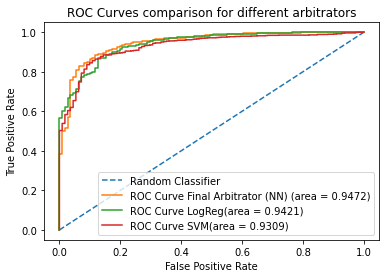

Path to plot: C:\Users\SWONG\PRS_project\Model\Final_Arbitrator_6lyr_binaryCross_Weight5_YesAug_0_roc.png


In [16]:
#plotting ROC
fpr, tpr, thresholds = metrics.roc_curve(Y_test, raw_prob_class_mel, pos_label=0)
fpr1, tpr1, thresholds1 = roc_curve(Y_test, lr_pred_proba[:,1])
fpr2, tpr2, thresholds2 = roc_curve(Y_test, svm_pred_proba[:,1])

plt.figure()
plt.plot([0,1],[0,1],'--', label='Random Classifier')
plt.plot(tpr,fpr,label='ROC Curve Final Arbitrator (NN) (area = %0.4f)' %roc_auc)
plt.plot(fpr1,tpr1,label='ROC Curve LogReg(area = %0.4f)' %roc_auc_lr)
plt.plot(fpr2,tpr2,label='ROC Curve SVM(area = %0.4f)' %roc_auc_svm)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curves comparison for different arbitrators")
plt.legend(loc="lower right")

roc_plotpath  = model_path + model_name_NN.split('.')[0] + '_roc.png'
plt.savefig(roc_plotpath)
plt.show()
print("Path to plot:", roc_plotpath)

# Plot Precision-Recall curve and save

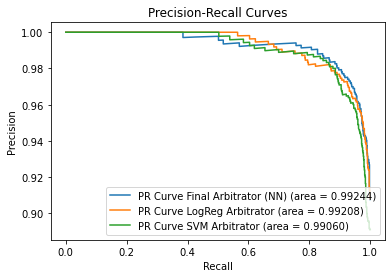

Path to plot: C:\Users\SWONG\PRS_project\Model\PR_Curves.png


In [17]:
# plot precision-recall curve
precision1, recall1, thresholds1 = precision_recall_curve(Y_test, raw_prob_class_mel)
precision2, recall2, thresholds2 = precision_recall_curve(Y_test, lr_pred_proba[:,1])
precision3, recall3, thresholds3 = precision_recall_curve(Y_test, svm_pred_proba[:,1])

plt.figure()
plt.plot(recall1,precision1,label='PR Curve Final Arbitrator (NN) (area = %0.5f)' %metrics.auc(recall1,precision1))
plt.plot(recall2,precision2,label='PR Curve LogReg Arbitrator (area = %0.5f)' %metrics.auc(recall2,precision2))
plt.plot(recall3,precision3,label='PR Curve SVM Arbitrator (area = %0.5f)' %metrics.auc(recall3,precision3))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curves")
plt.legend(loc="lower right")

PR_curce_plotpath  = model_path + 'PR_Curves.png'
plt.savefig(roc_plotpath)
plt.show()
print("Path to plot:", PR_curce_plotpath)